# ADS-508-01-SP23 Team 8: Final Project

# Setup Database and Athena Tables

Much of the code is modified from `Fregly, C., & Barth, A. (2021). Data science on AWS: Implementing end-to-end, continuous AI and machine learning pipelines. O’Reilly.`

## Install missing dependencies

[PyAthena](https://pypi.org/project/PyAthena/) is a Python DB API 2.0 (PEP 249) compliant client for Amazon Athena.

In [2]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
!pip install missingno

## Globally import libraries

In [3]:
import boto3
from botocore.client import ClientError
import sagemaker
import pandas as pd
from pyathena import connect
from IPython.core.display import display, HTML
import missingno as msno

## Instantiate AWS SageMaker session

In [4]:
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
def_bucket = sagemaker_session.default_bucket()
bucket = 'sagemaker-us-east-ads508-sp23-t8'

s3 = boto3.Session().client(service_name="s3",
                            region_name=region)

In [5]:
setup_s3_bucket_passed = False
ingest_create_athena_db_passed = False
ingest_create_athena_table_tsv_passed = False

In [6]:
print(f"Default bucket: {def_bucket}")
print(f"Public T8 bucket: {bucket}")

Default bucket: sagemaker-us-east-1-657724983756
Public T8 bucket: sagemaker-us-east-ads508-sp23-t8


## Verify S3 Bucket Creation

In [7]:
%%bash

aws s3 ls s3://${bucket}/

2023-03-16 17:05:02 aws-athena-query-results-657724983756-us-east-1
2023-03-02 16:56:48 sagemaker-studio-657724983756-5nh7ydsouq7
2023-03-02 17:25:41 sagemaker-studio-657724983756-7yc8bp8xk0b
2023-03-02 17:01:51 sagemaker-us-east-1-657724983756
2023-03-17 05:19:31 sagemaker-us-east-ads508-sp23-t8


In [8]:
response = None

try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print(f"[ERROR] Cannot find bucket {bucket} in {response} due to {e}.")

{'ResponseMetadata': {'RequestId': 'BBEQF9XSNG4WF478', 'HostId': 'tDY+7igr8D8leg4pYd7rNR7ik1XZzoLm4zY8ChOAwpUvnVE7Cvw8uuJghqh3SAYU9o0VL1U4Hg4=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'tDY+7igr8D8leg4pYd7rNR7ik1XZzoLm4zY8ChOAwpUvnVE7Cvw8uuJghqh3SAYU9o0VL1U4Hg4=', 'x-amz-request-id': 'BBEQF9XSNG4WF478', 'date': 'Sun, 26 Mar 2023 18:04:25 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'server': 'AmazonS3'}, 'RetryAttempts': 0}}


In [9]:
%store setup_s3_bucket_passed

Stored 'setup_s3_bucket_passed' (bool)


## Query Athena Database

In [10]:
database_name = "ads508_t8"

In [11]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = f"s3://{def_bucket}/athena/staging"
print(s3_staging_dir)

s3://sagemaker-us-east-1-657724983756/athena/staging


In [12]:
conn = connect(region_name=region,
               s3_staging_dir=s3_staging_dir)

### Verify The Database Has Been Created Succesfully

In [13]:
show_db_stmnt = "SHOW DATABASES"

df_show = pd.read_sql(show_db_stmnt,
                      conn)
df_show.head(17)

,database_name
0,ads508_t8
1,default
2,dsoaws
3,sagemaker_featurestore


In [14]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [15]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [16]:
cen_tsv_tbl_name = 'census'
ceb_tsv_tbl_name = 'census_block'
evi_tsv_tbl_name = 'evictions'
cri_tsv_tbl_name = 'crime'
cri_pqt_tbl_name = 'crime_pqt'
grd_tsv_tbl_name = 'grad_outcomes'
hsi_tsv_tbl_name = 'hs_info'
job_tsv_tbl_name = 'jobs'

In [17]:
# Set S3 path to Parquet data
#abt_s3_data_path = f"s3://{def_bucket}/team_8_data/ABT"

cen_tsv_tbl_name = 'census'
abt_tbl_name = 'abt'
drop_abt_tbl_stmnt = f"""DROP TABLE IF EXISTS {database_name}.{abt_tbl_name}"""

# SQL statement to execute
create_abt_tble_stmnt = f"""
CREATE TABLE IF NOT EXISTS {database_name}.{abt_tbl_name}
WITH (
    external_location = '{abt_s3_data_path}'
    )
AS
SELECT
        cen.censustract,
        cen.borough,
        cen.totalpop,
        cen.men,
        cen.women,
        cen.hispanic,
        cen.white,
        cen.black,
        cen.native,
        cen.asian,
        cen.citizen,
        cen.income,
        cen.poverty,
        cen.childpoverty,
        cen.professional,
        cen.service,
        cen.office,
        cen.construction,
        cen.production,
        cen.drive,
        cen.carpool,
        cen.transit,
        cen.walk,
        cen.othertransp,
        cen.workathome,
        cen.meancommute,
        cen.employed,
        cen.privatework,
        cen.publicwork,
        cen.selfemployed,
        cen.familywork,
        cen.unemployment,
        ceb.blockCode,
        ceb.min_lat,
        ceb.max_lat,
        ceb.min_long,
        ceb.max_long
FROM {database_name}.{cen_tsv_tbl_name} AS cen
LEFT JOIN (
    SELECT
        substr(blockCode,1,11) AS blockCode,
        count(*),
        min(latitude) AS min_lat,
        max(latitude) AS max_lat,
        min(longitude) AS min_long,
        max(longitude) AS max_long     
    FROM {database_name}.{ceb_tsv_tbl_name}
    GROUP BY substr(blockCode,1,11)
    ORDER BY count(*) DESC
    LIMIT 50000
    ) AS ceb
    ON cen.censustract = substr(ceb.blockCode,1,11)
"""

print(f'Create table statement:\n{create_abt_tble_stmnt}')

pd.read_sql(drop_abt_tbl_stmnt,
            conn)

pd.read_sql(create_abt_tble_stmnt,
            conn)

In [18]:
abt_select_to_join_stmnt01 = f"""
SELECT
    cen.censustract,
    cen.borough,
    cen.totalpop,
    cen.men,
    cen.women,
    cen.hispanic,
    cen.white,
    cen.black,
    cen.native,
    cen.asian,
    cen.citizen,
    cen.income,
    cen.poverty,
    cen.childpoverty,
    cen.professional,
    cen.service,
    cen.office,
    cen.construction,
    cen.production,
    cen.drive,
    cen.carpool,
    cen.transit,
    cen.walk,
    cen.othertransp,
    cen.workathome,
    cen.meancommute,
    cen.employed,
    cen.privatework,
    cen.publicwork,
    cen.selfemployed,
    cen.familywork,
    cen.unemployment,
    cvi.blockCode,
    cvi.eviction_count_x_lat_long
FROM {database_name}.{cen_tsv_tbl_name} AS cen
LEFT JOIN (
    SELECT
        ceb.blockCode AS blockCode,
        sum(evi.eviction_count_x_lat_long) AS eviction_count_x_lat_long
    FROM (
        SELECT
            substr(blockCode,1,11) AS blockCode,
            count(*),
            min(latitude) AS min_lat,
            max(latitude) AS max_lat,
            min(longitude) AS min_long,
            max(longitude) AS max_long     
        FROM {database_name}.{ceb_tsv_tbl_name}
        GROUP BY substr(blockCode,1,11)
        ORDER BY count(*) DESC
        ) AS ceb
    INNER JOIN (
        SELECT
            CAST(latitude AS DOUBLE) AS latitude,
            CAST(longitude AS DOUBLE) AS longitude,
            count(*) AS eviction_count_x_lat_long
        FROM {database_name}.{evi_tsv_tbl_name}
        WHERE latitude != ''
        GROUP BY latitude, longitude
        ORDER BY count(*) DESC
        ) AS evi
    ON evi.latitude >= ceb.min_lat
        AND evi.latitude <= ceb.max_lat
        AND evi.longitude >= ceb.min_long
        AND evi.longitude <= ceb.max_long
    GROUP BY ceb.blockCode
    LIMIT 50000
    ) AS cvi
    ON cen.censustract = cvi.blockCode
ORDER BY cen.censustract
"""

print(abt_select_to_join_stmnt01)

abt_select_to_join_df01 = pd.read_sql(abt_select_to_join_stmnt01,
                                      conn)
print(abt_select_to_join_df01.shape)
display(abt_select_to_join_df01.head(15))


SELECT
    cen.censustract,
    cen.borough,
    cen.totalpop,
    cen.men,
    cen.women,
    cen.hispanic,
    cen.white,
    cen.black,
    cen.native,
    cen.asian,
    cen.citizen,
    cen.income,
    cen.poverty,
    cen.childpoverty,
    cen.professional,
    cen.service,
    cen.office,
    cen.construction,
    cen.production,
    cen.drive,
    cen.carpool,
    cen.transit,
    cen.walk,
    cen.othertransp,
    cen.workathome,
    cen.meancommute,
    cen.employed,
    cen.privatework,
    cen.publicwork,
    cen.selfemployed,
    cen.familywork,
    cen.unemployment,
    cvi.blockCode,
    cvi.eviction_count_x_lat_long
FROM ads508_t8.census AS cen
LEFT JOIN (
    SELECT
        ceb.blockCode AS blockCode,
        sum(evi.eviction_count_x_lat_long) AS eviction_count_x_lat_long
    FROM (
        SELECT
            substr(blockCode,1,11) AS blockCode,
            count(*),
            min(latitude) AS min_lat,
            max(latitude) AS max_lat,
            min(longitude)

,censustract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment,blockCode,eviction_count_x_lat_long
0,36005000100,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,1.6,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,None,NaN
1,36005000200,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7,36005000200,31.0
2,36005000400,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5,36005000400,46.0
3,36005001600,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7,36005001600,10.0
4,36005001900,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2,36005001900,230.0
5,36005002000,Bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2,36005002000,69.0
6,36005002300,Bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,...,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9,None,NaN
7,36005002400,Bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,...,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0,36005002400,169.0
8,36005002500,Bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,...,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4,36005002500,22.0
9,36005002701,Bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,...,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2,None,NaN


In [19]:
ceb_select_to_join_stmnt01 = f"""
SELECT
    substr(blockCode,1,11) AS blockCode,
    count(*),
    min(latitude) AS min_lat,
    max(latitude) AS max_lat,
    min(longitude) AS min_long,
    max(longitude) AS max_long     
FROM {database_name}.{ceb_tsv_tbl_name}
GROUP BY substr(blockCode,1,11)
ORDER BY count(*) DESC
"""

print(ceb_select_to_join_stmnt01)

ceb_select_to_join_df01 = pd.read_sql(ceb_select_to_join_stmnt01,
                                      conn)
print(ceb_select_to_join_df01.shape)
display(ceb_select_to_join_df01.head(15))


SELECT
    substr(blockCode,1,11) AS blockCode,
    count(*),
    min(latitude) AS min_lat,
    max(latitude) AS max_lat,
    min(longitude) AS min_long,
    max(longitude) AS max_long     
FROM ads508_t8.census_block
GROUP BY substr(blockCode,1,11)
ORDER BY count(*) DESC

(2995, 6)


,blockCode,_col1,min_lat,max_lat,min_long,max_long
0,36081990100,1816,40.491307,40.584020,-74.039397,-73.757638
1,36085990100,1198,40.480000,40.604372,-74.257839,-74.036231
2,34025990000,917,40.480000,40.525226,-74.093216,-73.887437
3,36059990400,690,40.534271,40.579497,-73.767136,-73.650000
4,36059301000,412,40.819196,40.877990,-73.751307,-73.653166
5,36081107202,366,40.586281,40.645075,-73.852613,-73.767136
6,36047070203,327,40.579497,40.642814,-73.890603,-73.833618
7,34017012700,305,40.712915,40.776231,-74.143869,-74.077387
8,34013980200,297,40.674472,40.715176,-74.200854,-74.115377
9,36081071600,286,40.622462,40.663166,-73.830452,-73.748141


### Select statements to prepare for full join - `evictions` table

In [20]:
# Display full Evictions table for review
evi_full_select_stmnt01 = f"""
    SELECT
        *
    FROM {database_name}.{evi_tsv_tbl_name}
    WHERE executed_date <> ''
    LIMIT 100
    """

# Display SQL statement
print(evi_full_select_stmnt01)

# Run SQL statement against Athena table
evi_full_select_df01 = pd.read_sql(evi_full_select_stmnt01,
                                   conn)
# Display results
print(evi_full_select_df01.shape)
display(evi_full_select_df01.head(11))


    SELECT
        *
    FROM ads508_t8.evictions
    WHERE executed_date <> ''
    LIMIT 100
    
(100, 20)


,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,residential_or_commercial,borough,eviction_postcode,ejectment,eviction_or_legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
0,56037/17,339568,547 EAST 168TH STREET,3H,02/26/2018,Thomas,Bia,Residential,BRONX,10456,Not an Ejectment,Possession,40.830857,-73.905191,3,16,145,2004227,2026100065,Claremont-Bathgate
1,B047517/19,409031,4014 CARPENTER AVENUE,4B,11/16/2022,Richard,McCoy,Residential,BRONX,10466,Not an Ejectment,Possession,40.889878,-73.862686,12,12,408,2063060,2048280031,Williamsbridge-Olinville
2,15068/17,334442,655 EAST 224TH STREET,1,09/29/2017,Thomas,Bia,Residential,BRONX,10467,Not an Ejectment,Possession,40.887599,-73.862391,12,12,394,2062985,2048260028,Williamsbridge-Olinville
3,58273/18,025388,1551 DEAN STREET,1ST FLOOR,07/12/2018,Gary,Rose,Residential,BROOKLYN,11213,Not an Ejectment,Possession,40.676166,-73.936661,8,36,311,3388499,3013400049,Crown Heights North
4,14866/19A,097278,718 PENFIELD STREET,2-F,10/24/2019,Justin,Grossman,Residential,BRONX,10470,Not an Ejectment,Possession,40.904888,-73.849089,12,11,442,2071873,2051130039,Woodlawn-Wakefield
5,66703/18BX,090391,2032 EAST 177TH ST A /K/A 2032 CROSS BRONX EXP...,1E,07/30/2019,Justin,Grossman,Residential,BRONX,10472,Not an Ejectment,Possession,40.831685,-73.856168,9,18,78,2026230,2038030019,Westchester-Unionport
6,98925/17,075402,175 WOODRUFF AVENUE,GARDEN APARTMENT,06/01/2018,Justin,Grossman,Residential,BROOKLYN,11226,Not an Ejectment,Possession,40.654641,-73.960291,14,40,50803,3115933,3050540052,Flatbush
7,304057/20,107717,555 TENTH AVENUE,32I,04/18/2022,Justin,Grossman,Residential,MANHATTAN,10018,Not an Ejectment,Possession,40.758888,-73.996022,4,3,117,1089722,1010697501,Hudson Yards-Chelsea-Flatiron-Union Square
8,210706/18,085502,2201 FIRST AVENUE,05B,03/14/2019,Henry,Daley,Residential,MANHATTAN,10029,Not an Ejectment,Possession,40.794176,-73.936754,11,8,180,1081091,1016840001,East Harlem North
9,B806500/18,396012,281 EAST 143RD STREET,07A,01/17/2019,Richard,McCoy,Residential,BRONX,10451,Not an Ejectment,Possession,40.814845,-73.924083,1,8,51,2091116,2023240001,Mott Haven-Port Morris


In [21]:
# Aggregate Evictions table based on borough and event year
evi_borough_year_stmnt01 = f"""
    SELECT
        lower(borough) AS borough,
        CAST(YEAR(date_parse(executed_date, '%m/%d/%Y')) AS INT) - 2022 AS relative_data_year,
        count(*) AS annual_evictions_x_borough
    FROM {database_name}.{evi_tsv_tbl_name}
    WHERE executed_date <> ''
        AND CAST(YEAR(date_parse(executed_date, '%m/%d/%Y')) AS INT) BETWEEN 2018 AND 2022
    GROUP BY borough, YEAR(date_parse(executed_date, '%m/%d/%Y'))
    ORDER BY borough, YEAR(date_parse(executed_date, '%m/%d/%Y'))
    LIMIT 10000
    """

# Display SQL statement
print(evi_borough_year_stmnt01)

# Run SQL statement against Athena table
evi_borough_year_df01 = pd.read_sql(evi_borough_year_stmnt01,
                                   conn)
# Display results
print(evi_borough_year_df01.shape)
display(evi_borough_year_df01.head(35))

evi_borough_year_df02 = evi_borough_year_df01.pivot_table(index = 'borough',
                                                          columns = 'relative_data_year',
                                                          values = 'annual_evictions_x_borough',
                                                          aggfunc = 'sum',
                                                          fill_value = 0)
print(evi_borough_year_df02.shape)
display(evi_borough_year_df02.head(35))


    SELECT
        lower(borough) AS borough,
        CAST(YEAR(date_parse(executed_date, '%m/%d/%Y')) AS INT) - 2022 AS relative_data_year,
        count(*) AS annual_evictions_x_borough
    FROM ads508_t8.evictions
    WHERE executed_date <> ''
        AND CAST(YEAR(date_parse(executed_date, '%m/%d/%Y')) AS INT) BETWEEN 2018 AND 2022
    GROUP BY borough, YEAR(date_parse(executed_date, '%m/%d/%Y'))
    ORDER BY borough, YEAR(date_parse(executed_date, '%m/%d/%Y'))
    LIMIT 10000
    
(25, 3)


,borough,relative_data_year,annual_evictions_x_borough
0,bronx,-4,7140
1,bronx,-3,6244
2,bronx,-2,1088
3,bronx,-1,29
4,bronx,0,1174
5,brooklyn,-4,6157
6,brooklyn,-3,5312
7,brooklyn,-2,1005
8,brooklyn,-1,100
9,brooklyn,0,1864


(5, 5)


relative_data_year,-4,-3,-2,-1,0
borough,,,,,
bronx,7140,6244,1088,29,1174
brooklyn,6157,5312,1005,100,1864
manhattan,3390,2818,521,68,930
queens,4452,3705,696,36,811
staten island,691,636,112,35,271


In [22]:
evi_ceb_join_select_stmnt01 = f"""
SELECT
    ceb.blockCode AS census_tract,
    evi.year,
    sum(evi.eviction_count_x_lat_long) AS annual_evictions_x_census_tract
FROM (
    SELECT
        substr(blockCode,1,11) AS blockCode,
        count(*),
        min(latitude) AS min_lat,
        max(latitude) AS max_lat,
        min(longitude) AS min_long,
        max(longitude) AS max_long     
    FROM {database_name}.{ceb_tsv_tbl_name}
    GROUP BY substr(blockCode,1,11)
    ORDER BY count(*) DESC
    ) AS ceb
INNER JOIN (
    SELECT
        CAST(latitude AS DOUBLE) AS latitude,
        CAST(longitude AS DOUBLE) AS longitude,
        CAST(YEAR(date_parse(executed_date, '%m/%d/%Y')) AS INT) AS year,    
        count(*) AS eviction_count_x_lat_long
    FROM {database_name}.{evi_tsv_tbl_name}
    WHERE latitude != ''
    GROUP BY latitude, longitude, YEAR(date_parse(executed_date, '%m/%d/%Y'))
    ORDER BY count(*) DESC
    ) AS evi
    ON evi.latitude >= ceb.min_lat
        AND evi.latitude <= ceb.max_lat
        AND evi.longitude >= ceb.min_long
        AND evi.longitude <= ceb.max_long
GROUP BY ceb.blockCode, evi.year
ORDER BY ceb.blockCode, evi.year
LIMIT 50000
"""

print(evi_ceb_join_select_stmnt01)

evi_ceb_join_select_df01 = pd.read_sql(evi_ceb_join_select_stmnt01,
                           conn)
print(evi_ceb_join_select_df01.shape)
display(evi_ceb_join_select_df01.head(15))

evi_ceb_join_select_df02 = evi_ceb_join_select_df01.pivot_table(index = 'census_tract',
                                                                columns = 'year',
                                                                values = 'annual_evictions_x_census_tract',
                                                                aggfunc = 'sum',
                                                                fill_value = 0)
print(evi_ceb_join_select_df02.shape)
display(evi_ceb_join_select_df02.head(35))


SELECT
    ceb.blockCode AS census_tract,
    evi.year,
    sum(evi.eviction_count_x_lat_long) AS annual_evictions_x_census_tract
FROM (
    SELECT
        substr(blockCode,1,11) AS blockCode,
        count(*),
        min(latitude) AS min_lat,
        max(latitude) AS max_lat,
        min(longitude) AS min_long,
        max(longitude) AS max_long     
    FROM ads508_t8.census_block
    GROUP BY substr(blockCode,1,11)
    ORDER BY count(*) DESC
    ) AS ceb
INNER JOIN (
    SELECT
        CAST(latitude AS DOUBLE) AS latitude,
        CAST(longitude AS DOUBLE) AS longitude,
        CAST(YEAR(date_parse(executed_date, '%m/%d/%Y')) AS INT) AS year,    
        count(*) AS eviction_count_x_lat_long
    FROM ads508_t8.evictions
    WHERE latitude != ''
    GROUP BY latitude, longitude, YEAR(date_parse(executed_date, '%m/%d/%Y'))
    ORDER BY count(*) DESC
    ) AS evi
    ON evi.latitude >= ceb.min_lat
        AND evi.latitude <= ceb.max_lat
        AND evi.longitude >= ceb.min_long
     

,census_tract,year,annual_evictions_x_census_tract
0,34003013001,2017,9
1,34003013001,2018,11
2,34003013001,2019,6
3,34003013001,2021,1
4,34003013001,2022,6
5,34003013001,2023,1
6,34003016000,2017,14
7,34003016000,2018,13
8,34003016000,2019,16
9,34003016000,2020,2


(1306, 7)


year,2017,2018,2019,2020,2021,2022,2023
census_tract,,,,,,,
34003013001,9,11,6,0,1,6,1
34003016000,14,13,16,2,2,1,0
34017010800,2,2,5,0,0,0,0
36005000200,9,10,10,0,0,1,1
36005000400,10,16,15,0,0,5,0
36005001600,3,2,4,0,0,1,0
36005001900,74,67,53,9,0,22,5
36005002000,20,14,29,3,0,3,0
36005002400,50,43,65,5,0,6,0


### Select statements to prepare for full join - `crime_pqt` table

In [23]:
# Run query to review a sample of records
cri_full_select_stmnt01 = f"""
    SELECT
        *
    FROM {database_name}.{cri_pqt_tbl_name}
    LIMIT 10000
    """

# Display SQL statement
print(cri_full_select_stmnt01)

# Run SQL statement against Athena table
cri_full_select_df01 = pd.read_sql(cri_full_select_stmnt01,
                                   conn)
# Display results
print(cri_full_select_df01.shape)
display(cri_full_select_df01.head(5))


    SELECT
        *
    FROM ads508_t8.crime_pqt
    LIMIT 10000
    
(10000, 35)


,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,cmplnt_to_dt,cmplnt_to_tm,addr_pct_cd,rpt_dt,ky_cd,ofns_desc,pd_cd,...,latitude,longitude,lat_lon,patrol_boro,station_name,vic_age_group,vic_race,vic_sex,law_cat_cd,borough
0,437421679,06/03/2012,02:00:00,06/03/2012,02:18:00,23,06/03/2012,113,FORGERY,729,...,40.794501225,-73.944636047,"(40.794501225, -73.944636047)",PATROL BORO MAN NORTH,,25-44,WHITE HISPANIC,M,FELONY,MANHATTAN
1,853340644,10/02/2015,12:00:00,10/02/2015,13:00:00,13,10/02/2015,107,BURGLARY,231,...,40.739528656,-73.989673657,"(40.739528656, -73.989673657)",PATROL BORO MAN SOUTH,,UNKNOWN,UNKNOWN,D,FELONY,MANHATTAN
2,835396284,08/28/2016,03:10:00,08/28/2016,03:14:00,26,08/28/2016,118,DANGEROUS WEAPONS,792,...,40.810637728,-73.958274067,"(40.810637728, -73.958274067)",PATROL BORO MAN NORTH,,UNKNOWN,UNKNOWN,E,FELONY,MANHATTAN
3,702728262,03/13/2014,17:10:00,03/14/2014,08:20:00,18,03/14/2014,107,BURGLARY,213,...,40.756717855,-73.980639964,"(40.756717855, -73.980639964)",PATROL BORO MAN SOUTH,,,UNKNOWN,D,FELONY,MANHATTAN
4,267017062,05/06/2015,19:45:00,,,14,05/06/2015,111,POSSESSION OF STOLEN PROPERTY,494,...,40.753464076,-73.994399743,"(40.753464076, -73.994399743)",PATROL BORO MAN SOUTH,,45-64,WHITE,M,FELONY,MANHATTAN


# Aggregate Evictions table based on borough and event year
crf_borough_year_type_stmnt01 = f"""
SELECT
    lower(borough) AS borough,
    CONCAT(CAST(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_cat_cd) AS year_w_complaint
FROM {database_name}.{cri_tsv_tbl_name}
WHERE cmplnt_fr_dt <> ''
    AND YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) > 2010
ORDER BY borough, concat(cast(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_cat_cd)
LIMIT 2000000
"""

# Display SQL statement
print(crf_borough_year_type_stmnt01)

# Run SQL statement against Athena table
crf_borough_year_type_df01 = pd.read_sql(crf_borough_year_type_stmnt01,
                                         conn)
# Display results
print(crf_borough_year_type_df01.shape)
display(crf_borough_year_type_df01.head(11))

In [24]:
# Aggregate Evictions table based on borough and event year
cri_borough_year_type_stmnt01 = f"""
SELECT
    lower(borough) AS borough,
    CAST(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS INT) - 2021 AS relative_data_year,
    law_cat_cd AS complaint_type,
    COUNT(*) AS annual_complaint_counts
FROM {database_name}.{cri_pqt_tbl_name}
WHERE cmplnt_fr_dt <> ''
    AND YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) BETWEEN 2017 AND 2021
GROUP BY borough, YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')), law_cat_cd
ORDER BY borough, YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')), law_cat_cd
LIMIT 100000
"""

# Display SQL statement
print(cri_borough_year_type_stmnt01)

# Run SQL statement against Athena table
cri_borough_year_type_df01 = pd.read_sql(cri_borough_year_type_stmnt01,
                                         conn)
# Display results
print(cri_borough_year_type_df01.shape)
display(cri_borough_year_type_df01.head(35))


SELECT
    lower(borough) AS borough,
    CAST(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS INT) - 2021 AS relative_data_year,
    law_cat_cd AS complaint_type,
    COUNT(*) AS annual_complaint_counts
FROM ads508_t8.crime_pqt
WHERE cmplnt_fr_dt <> ''
    AND YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) BETWEEN 2017 AND 2021
GROUP BY borough, YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')), law_cat_cd
ORDER BY borough, YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')), law_cat_cd
LIMIT 100000

(83, 4)


,borough,relative_data_year,complaint_type,annual_complaint_counts
0,bronx,-4,FELONY,591
1,bronx,-4,MISDEMEANOR,1197
2,bronx,-4,VIOLATION,343
3,bronx,-3,FELONY,517
4,bronx,-3,MISDEMEANOR,1156
5,bronx,-3,VIOLATION,349
6,bronx,-2,FELONY,584
7,bronx,-2,MISDEMEANOR,1159
8,bronx,-2,VIOLATION,349
9,bronx,-1,FELONY,562


In [25]:
# Aggregate Evictions table based on borough and event year
cri_borough_year_type_stmnt02 = f"""
SELECT
    lower(borough) AS borough,
    CONCAT(CAST(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_cat_cd) AS year_w_complaint,
    COUNT(*) AS annual_complaint_counts
FROM {database_name}.{cri_pqt_tbl_name}
WHERE cmplnt_fr_dt <> ''
    AND YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) >= 2017
GROUP BY borough, concat(cast(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_cat_cd)
ORDER BY borough, concat(cast(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_cat_cd)
LIMIT 100000
"""

# Display SQL statement
print(cri_borough_year_type_stmnt02)

# Run SQL statement against Athena table
cri_borough_year_type_df12 = pd.read_sql(cri_borough_year_type_stmnt02,
                                         conn)
# Display results
print(cri_borough_year_type_df12.shape)
display(cri_borough_year_type_df12.head(35))

cri_borough_year_type_df13 = cri_borough_year_type_df12.pivot_table(index = 'borough',
                                                                    columns = 'year_w_complaint',
                                                                    values = 'annual_complaint_counts',
                                                                    aggfunc = 'sum',
                                                                    fill_value = 0)
print(cri_borough_year_type_df13.shape)
display(cri_borough_year_type_df13.head(35))


SELECT
    lower(borough) AS borough,
    CONCAT(CAST(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_cat_cd) AS year_w_complaint,
    COUNT(*) AS annual_complaint_counts
FROM ads508_t8.crime_pqt
WHERE cmplnt_fr_dt <> ''
    AND YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) >= 2017
GROUP BY borough, concat(cast(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_cat_cd)
ORDER BY borough, concat(cast(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_cat_cd)
LIMIT 100000

(83, 3)


,borough,year_w_complaint,annual_complaint_counts
0,bronx,2017 - FELONY,591
1,bronx,2017 - MISDEMEANOR,1197
2,bronx,2017 - VIOLATION,343
3,bronx,2018 - FELONY,517
4,bronx,2018 - MISDEMEANOR,1156
5,bronx,2018 - VIOLATION,349
6,bronx,2019 - FELONY,584
7,bronx,2019 - MISDEMEANOR,1159
8,bronx,2019 - VIOLATION,349
9,bronx,2020 - FELONY,562


(5, 15)


year_w_complaint,2017 - FELONY,2017 - MISDEMEANOR,2017 - VIOLATION,2018 - FELONY,2018 - MISDEMEANOR,2018 - VIOLATION,2019 - FELONY,2019 - MISDEMEANOR,2019 - VIOLATION,2020 - FELONY,2020 - MISDEMEANOR,2020 - VIOLATION,2021 - FELONY,2021 - MISDEMEANOR,2021 - VIOLATION
borough,,,,,,,,,,,,,,,
bronx,591,1197,343,517,1156,349,584,1159,349,562,947,296,618,900,343
brooklyn,857,1439,409,855,1341,409,854,1328,405,813,1222,384,768,1281,453
manhattan,694,1276,279,672,1267,294,736,1296,308,631,985,277,688,1161,266
queens,602,943,280,578,947,298,588,1027,316,594,894,299,618,983,291
staten island,96,239,76,97,227,75,90,197,87,108,185,91,91,169,93


In [26]:
cri_ceb_join_select_stmnt01 = f"""
SELECT
    ceb.blockCode AS census_tract,
    cri.year,
    sum(cri.complaint_count_x_lat_long) AS annual_complaints_x_census_tract
FROM (
    SELECT
        substr(blockCode,1,11) AS blockCode,
        count(*),
        min(latitude) AS min_lat,
        max(latitude) AS max_lat,
        min(longitude) AS min_long,
        max(longitude) AS max_long     
    FROM {database_name}.{ceb_tsv_tbl_name}
    GROUP BY substr(blockCode,1,11)
    ORDER BY count(*) DESC
    ) AS ceb
INNER JOIN (
    SELECT
        CAST(latitude AS DOUBLE) AS latitude,
        CAST(longitude AS DOUBLE) AS longitude,
        CONCAT(CAST(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_cat_cd) AS year,    
        count(*) AS complaint_count_x_lat_long
    FROM {database_name}.{cri_pqt_tbl_name}
    WHERE cmplnt_fr_dt <> ''
        AND latitude != ''
        AND YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) >= 2017
    GROUP BY latitude, longitude, CONCAT(CAST(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_cat_cd)
    ORDER BY count(*) DESC
    ) AS cri
    ON cri.latitude >= ceb.min_lat
        AND cri.latitude <= ceb.max_lat
        AND cri.longitude >= ceb.min_long
        AND cri.longitude <= ceb.max_long
GROUP BY ceb.blockCode, cri.year
ORDER BY ceb.blockCode, cri.year
LIMIT 100000
"""

print(cri_ceb_join_select_stmnt01)

cri_ceb_join_select_df01 = pd.read_sql(cri_ceb_join_select_stmnt01,
                           conn)
print(cri_ceb_join_select_df01.shape)
display(cri_ceb_join_select_df01.head(15))


cri_ceb_join_select_df02 = cri_ceb_join_select_df01.pivot_table(index = 'census_tract',
                                                                columns = 'year',
                                                                values = 'annual_complaints_x_census_tract',
                                                                aggfunc = 'sum',
                                                                fill_value = 0)
print(cri_ceb_join_select_df02.shape)
display(cri_ceb_join_select_df02.head(35))


SELECT
    ceb.blockCode AS census_tract,
    cri.year,
    sum(cri.complaint_count_x_lat_long) AS annual_complaints_x_census_tract
FROM (
    SELECT
        substr(blockCode,1,11) AS blockCode,
        count(*),
        min(latitude) AS min_lat,
        max(latitude) AS max_lat,
        min(longitude) AS min_long,
        max(longitude) AS max_long     
    FROM ads508_t8.census_block
    GROUP BY substr(blockCode,1,11)
    ORDER BY count(*) DESC
    ) AS ceb
INNER JOIN (
    SELECT
        CAST(latitude AS DOUBLE) AS latitude,
        CAST(longitude AS DOUBLE) AS longitude,
        CONCAT(CAST(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_cat_cd) AS year,    
        count(*) AS complaint_count_x_lat_long
    FROM ads508_t8.crime_pqt
    WHERE cmplnt_fr_dt <> ''
        AND latitude != ''
        AND YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) >= 2017
    GROUP BY latitude, longitude, CONCAT(CAST(YEAR(date_parse(cmplnt_fr_dt, '%m/%d/%Y')) AS varchar), ' - ', law_

,census_tract,year,annual_complaints_x_census_tract
0,34003013001,2017 - FELONY,6
1,34003013001,2017 - MISDEMEANOR,2
2,34003013001,2018 - FELONY,4
3,34003013001,2018 - MISDEMEANOR,4
4,34003013001,2018 - VIOLATION,2
5,34003013001,2019 - FELONY,4
6,34003013001,2019 - MISDEMEANOR,3
7,34003013001,2019 - VIOLATION,1
8,34003013001,2020 - FELONY,4
9,34003013001,2020 - MISDEMEANOR,4


(1365, 15)


year,2017 - FELONY,2017 - MISDEMEANOR,2017 - VIOLATION,2018 - FELONY,2018 - MISDEMEANOR,2018 - VIOLATION,2019 - FELONY,2019 - MISDEMEANOR,2019 - VIOLATION,2020 - FELONY,2020 - MISDEMEANOR,2020 - VIOLATION,2021 - FELONY,2021 - MISDEMEANOR,2021 - VIOLATION
census_tract,,,,,,,,,,,,,,,
34003013001,6,2,0,4,4,2,4,3,1,4,4,0,3,3,3
34003016000,1,2,0,1,5,0,3,1,0,1,1,0,2,1,1
34017005802,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
34017010800,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
34017980100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
34023003401,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
36005000100,12,10,0,5,9,0,4,9,0,6,4,0,1,3,1
36005000200,0,2,0,0,1,0,1,0,0,1,3,1,3,0,2
36005000400,3,4,0,0,1,0,2,6,1,0,1,0,2,0,2


### Select statements to prepare for full join - `grad_outcomes` table

In [27]:
# Run query to review a sample of records
grd_full_select_stmnt01 = f"""
SELECT
    grd.dbn,
    grd.school_name,
    grd.cohort,
    grd.total_grads_n,
    grd.dropped_out_n,
    hsi.borough,
    hsi.census_tract,
    hsi.bin
FROM {database_name}.{grd_tsv_tbl_name} AS grd
INNER JOIN {database_name}.{hsi_tsv_tbl_name} AS hsi
    ON grd.dbn = hsi.dbn
WHERE census_tract IS NOT NULL
ORDER BY hsi.census_tract ASC
LIMIT 100000
"""

# Display SQL statement
print(grd_full_select_stmnt01)

# Run SQL statement against Athena table
grd_full_select_df01 = pd.read_sql(grd_full_select_stmnt01,
                                   conn)
# Display results
print(grd_full_select_df01.shape)
display(grd_full_select_df01.head(7))


SELECT
    grd.dbn,
    grd.school_name,
    grd.cohort,
    grd.total_grads_n,
    grd.dropped_out_n,
    hsi.borough,
    hsi.census_tract,
    hsi.bin
FROM ads508_t8.grad_outcomes AS grd
INNER JOIN ads508_t8.hs_info AS hsi
    ON grd.dbn = hsi.dbn
WHERE census_tract IS NOT NULL
ORDER BY hsi.census_tract ASC
LIMIT 100000

(0, 8)


,dbn,school_name,cohort,total_grads_n,dropped_out_n,borough,census_tract,bin


In [28]:
# Run query to review a sample of records
grd_select_borough_stmnt01 = f"""
SELECT
    lower(hsi.borough) AS borough,
    CAST(grd.cohort AS INT) - 2006 AS relative_data_year,
    sum(CAST(grd.total_grads_n AS DOUBLE)) AS annual_grad_n,
    sum(CAST(grd.dropped_out_n AS DOUBLE)) AS annual_dropped_out_n
FROM {database_name}.{grd_tsv_tbl_name} AS grd
LEFT JOIN {database_name}.{hsi_tsv_tbl_name} AS hsi
    ON grd.dbn = hsi.dbn
WHERE total_grads_n <> 's'
    AND cohort != '2006 Aug'
    AND borough IS NOT null
    AND CAST(grd.cohort AS INT) BETWEEN 2002 AND 2006
GROUP BY hsi.borough, grd.cohort
ORDER BY hsi.borough, grd.cohort
LIMIT 100000
"""

# Display SQL statement
print(grd_select_borough_stmnt01)

# Run SQL statement against Athena table
grd_select_borough_df01 = pd.read_sql(grd_select_borough_stmnt01,
                                   conn)
# Display results
print(grd_select_borough_df01.shape)
display(grd_select_borough_df01.head(50))

grd_select_borough_df02 = grd_select_borough_df01.pivot_table(index = 'borough',
                                                              columns = 'relative_data_year',
                                                              values = ['annual_grad_n', 'annual_dropped_out_n'],
                                                              aggfunc = 'sum',
                                                              fill_value = 0)
print(grd_select_borough_df02.shape)
display(grd_select_borough_df02.head(35))


SELECT
    lower(hsi.borough) AS borough,
    CAST(grd.cohort AS INT) - 2006 AS relative_data_year,
    sum(CAST(grd.total_grads_n AS DOUBLE)) AS annual_grad_n,
    sum(CAST(grd.dropped_out_n AS DOUBLE)) AS annual_dropped_out_n
FROM ads508_t8.grad_outcomes AS grd
LEFT JOIN ads508_t8.hs_info AS hsi
    ON grd.dbn = hsi.dbn
WHERE total_grads_n <> 's'
    AND cohort != '2006 Aug'
    AND borough IS NOT null
    AND CAST(grd.cohort AS INT) BETWEEN 2002 AND 2006
GROUP BY hsi.borough, grd.cohort
ORDER BY hsi.borough, grd.cohort
LIMIT 100000

(25, 4)


,borough,relative_data_year,annual_grad_n,annual_dropped_out_n
0,bronx,-4,17130.0,2833.0
1,bronx,-3,22123.0,4494.0
2,bronx,-2,27594.0,4974.0
3,bronx,-1,31643.0,5112.0
4,bronx,0,33597.0,6251.0
5,brooklyn,-4,38539.0,8505.0
6,brooklyn,-3,44230.0,8488.0
7,brooklyn,-2,51985.0,8323.0
8,brooklyn,-1,53783.0,6934.0
9,brooklyn,0,56436.0,7878.0


(5, 10)


annual_dropped_out_n                           \
relative_data_year                   -4     -3    -2    -1     0   
borough                                                            
bronx                              2833   4494  4974  5112  6251   
brooklyn                           8505   8488  8323  6934  7878   
manhattan                          2741   3404  3079  2545  3211   
queens                            11220  10593  9598  9165  8777   
staten island                      2236   1852  1799  1657  2035   

                   annual_grad_n                              
relative_data_year            -4     -3     -2     -1      0  
borough                                                       
bronx                      17130  22123  27594  31643  33597  
brooklyn                   38539  44230  51985  53783  56436  
manhattan                  28721  30950  34333  38817  41153  
queens                     47027  50268  53307  57757  61196  
staten island              16133  16651  16391  18054  19483

In [29]:
# Run query to review a sample of records
grd_select_ct_stmnt01 = f"""
    SELECT
        hsi.census_tract,
        sum(CAST(grd.total_grads_n AS DOUBLE)) AS annual_grad_n,
        sum(CAST(grd.dropped_out_n AS DOUBLE)) AS annual_dropped_out_n
    FROM {database_name}.{grd_tsv_tbl_name} AS grd
    LEFT JOIN {database_name}.{hsi_tsv_tbl_name} AS hsi
    ON grd.dbn = hsi.dbn
    WHERE total_grads_n <> 's'
    GROUP BY hsi.census_tract
    ORDER BY hsi.census_tract
    LIMIT 100000
    """

# Display SQL statement
print(grd_select_ct_stmnt01)

# Run SQL statement against Athena table
grd_select_ct_df01 = pd.read_sql(grd_select_ct_stmnt01,
                                   conn)
# Display results
print(grd_select_ct_df01.shape)
display(grd_select_ct_df01.head(50))


    SELECT
        hsi.census_tract,
        sum(CAST(grd.total_grads_n AS DOUBLE)) AS annual_grad_n,
        sum(CAST(grd.dropped_out_n AS DOUBLE)) AS annual_dropped_out_n
    FROM ads508_t8.grad_outcomes AS grd
    LEFT JOIN ads508_t8.hs_info AS hsi
    ON grd.dbn = hsi.dbn
    WHERE total_grads_n <> 's'
    GROUP BY hsi.census_tract
    ORDER BY hsi.census_tract
    LIMIT 100000
    
(1, 3)


,census_tract,annual_grad_n,annual_dropped_out_n
0,None,1489323.0,308140.0


### Select statements to prepare for full join - `census` table

In [30]:
# Display full Evictions table for review
cen_full_select_stmnt01 = f"""
    SELECT
        censustract AS census_tract,
        lower(borough) AS borough,
        totalpop,
        men,
        women,
        hispanic,
        white,
        black,
        native,
        asian,
        citizen,
        income,
        incomeerr,
        incomepercap,
        incomepercaperr,
        poverty,
        childpoverty,
        professional,
        service,
        office,
        construction,
        production,
        drive,
        carpool,
        transit,
        walk,
        othertransp,
        workathome,
        meancommute,
        employed,
        privatework,
        publicwork,
        selfemployed,
        familywork,
        unemployment
    FROM {database_name}.{cen_tsv_tbl_name}
    WHERE childpoverty IS NOT NULL
    LIMIT 10000
    """

# Display SQL statement
print(cen_full_select_stmnt01)

# Run SQL statement against Athena table
cen_full_select_df01 = pd.read_sql(cen_full_select_stmnt01,
                                   conn)
# Display results
print(cen_full_select_df01.shape)
display(cen_full_select_df01.head(11))


    SELECT
        censustract AS census_tract,
        lower(borough) AS borough,
        totalpop,
        men,
        women,
        hispanic,
        white,
        black,
        native,
        asian,
        citizen,
        income,
        incomeerr,
        incomepercap,
        incomepercaperr,
        poverty,
        childpoverty,
        professional,
        service,
        office,
        construction,
        production,
        drive,
        carpool,
        transit,
        walk,
        othertransp,
        workathome,
        meancommute,
        employed,
        privatework,
        publicwork,
        selfemployed,
        familywork,
        unemployment
    FROM ads508_t8.census
    WHERE childpoverty IS NOT NULL
    LIMIT 10000
    
(2107, 35)


,census_tract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,36005000200,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,36005000400,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,36005001600,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,36005001900,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,36005002000,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
5,36005002300,bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
6,36005002400,bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
7,36005002500,bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
8,36005002701,bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2
9,36005002702,bronx,4778,2427,2351,71.3,1.6,26.2,0.0,0.0,...,7.1,0.7,0.5,44.0,1559,75.0,14.0,11.0,0.0,10.6


### Setup ABT version 1 by joining `census` table with pivot tables of other tables (`evictions`, `crime_pqt`, and `grad_outcomes`) based on `borough` feature

In [31]:
evi_borough_year_df03 = evi_borough_year_df02.reset_index()
cri_borough_year_type_df03 = cri_borough_year_type_df13.reset_index()
grd_select_borough_df03 = grd_select_borough_df02.reset_index()

display(cen_full_select_df01.head(10))

display(evi_borough_year_df03.head(5))
display(cri_borough_year_type_df03.head(5))
display(grd_select_borough_df03.head(5))

abt_df01 = pd.merge(cen_full_select_df01, evi_borough_year_df03, on='borough')
abt_df01 = pd.merge(abt_df01, cri_borough_year_type_df03, on='borough')
abt_df01 = pd.merge(abt_df01, grd_select_borough_df03, on='borough')
display(abt_df01)

,census_tract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,36005000200,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,36005000400,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,36005001600,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,36005001900,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,36005002000,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
5,36005002300,bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
6,36005002400,bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
7,36005002500,bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
8,36005002701,bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2
9,36005002702,bronx,4778,2427,2351,71.3,1.6,26.2,0.0,0.0,...,7.1,0.7,0.5,44.0,1559,75.0,14.0,11.0,0.0,10.6


relative_data_year,borough,-4,-3,-2,-1,0
0,bronx,7140,6244,1088,29,1174
1,brooklyn,6157,5312,1005,100,1864
2,manhattan,3390,2818,521,68,930
3,queens,4452,3705,696,36,811
4,staten island,691,636,112,35,271


year_w_complaint,borough,2017 - FELONY,2017 - MISDEMEANOR,2017 - VIOLATION,2018 - FELONY,2018 - MISDEMEANOR,2018 - VIOLATION,2019 - FELONY,2019 - MISDEMEANOR,2019 - VIOLATION,2020 - FELONY,2020 - MISDEMEANOR,2020 - VIOLATION,2021 - FELONY,2021 - MISDEMEANOR,2021 - VIOLATION
0,bronx,591,1197,343,517,1156,349,584,1159,349,562,947,296,618,900,343
1,brooklyn,857,1439,409,855,1341,409,854,1328,405,813,1222,384,768,1281,453
2,manhattan,694,1276,279,672,1267,294,736,1296,308,631,985,277,688,1161,266
3,queens,602,943,280,578,947,298,588,1027,316,594,894,299,618,983,291
4,staten island,96,239,76,97,227,75,90,197,87,108,185,91,91,169,93


borough annual_dropped_out_n                     \
relative_data_year                                  -4     -3    -2    -1   
0                           bronx                 2833   4494  4974  5112   
1                        brooklyn                 8505   8488  8323  6934   
2                       manhattan                 2741   3404  3079  2545   
3                          queens                11220  10593  9598  9165   
4                   staten island                 2236   1852  1799  1657   

                         annual_grad_n                              
relative_data_year     0            -4     -3     -2     -1      0  
0                   6251         17130  22123  27594  31643  33597  
1                   7878         38539  44230  51985  53783  56436  
2                   3211         28721  30950  34333  38817  41153  
3                   8777         47027  50268  53307  57757  61196  
4                   2035         16133  16651  16391  18054  19483

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,census_tract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,"(annual_dropped_out_n, -4)","(annual_dropped_out_n, -3)","(annual_dropped_out_n, -2)","(annual_dropped_out_n, -1)","(annual_dropped_out_n, 0)","(annual_grad_n, -4)","(annual_grad_n, -3)","(annual_grad_n, -2)","(annual_grad_n, -1)","(annual_grad_n, 0)"
0,36005000200,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
1,36005000400,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
2,36005001600,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
3,36005001900,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
4,36005002000,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,36085030301,staten island,4895,2371,2524,30.7,40.2,11.6,0.0,16.0,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2103,36085030302,staten island,6279,3093,3186,35.8,28.7,17.6,0.0,14.3,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2104,36085031901,staten island,2550,953,1597,27.1,6.2,60.4,0.0,6.3,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2105,36085031902,staten island,4611,2043,2568,20.9,14.7,61.9,0.0,0.9,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483


### Setup ABT version 2 by joining `census` table with pivot tables of other tables (`evictions`, `crime_pqt`, and `grad_outcomes`) based on `census_tract` or `borough` features

In [32]:
evi_ceb_join_select_df03 = evi_ceb_join_select_df02.reset_index()
cri_ceb_join_select_df03 = cri_ceb_join_select_df02.reset_index()
grd_select_borough_df03 = grd_select_borough_df02.reset_index()

display(cen_full_select_df01.head(10))

display(evi_ceb_join_select_df03.head(5))
display(cri_ceb_join_select_df03.head(5))
display(grd_select_borough_df03.head(5))

abt_df02 = pd.merge(cen_full_select_df01,
                    evi_ceb_join_select_df03,
                    how='left',
                    on='census_tract')
abt_df02 = pd.merge(abt_df02,
                    cri_ceb_join_select_df03,
                    how='left',
                    on='census_tract')
abt_df02 = pd.merge(abt_df02,
                    grd_select_borough_df03,
                    on='borough')
display(abt_df02)

,census_tract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,36005000200,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,36005000400,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,36005001600,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,36005001900,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,36005002000,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
5,36005002300,bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
6,36005002400,bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
7,36005002500,bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
8,36005002701,bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2
9,36005002702,bronx,4778,2427,2351,71.3,1.6,26.2,0.0,0.0,...,7.1,0.7,0.5,44.0,1559,75.0,14.0,11.0,0.0,10.6


year,census_tract,2017,2018,2019,2020,2021,2022,2023
0,34003013001,9,11,6,0,1,6,1
1,34003016000,14,13,16,2,2,1,0
2,34017010800,2,2,5,0,0,0,0
3,36005000200,9,10,10,0,0,1,1
4,36005000400,10,16,15,0,0,5,0


year,census_tract,2017 - FELONY,2017 - MISDEMEANOR,2017 - VIOLATION,2018 - FELONY,2018 - MISDEMEANOR,2018 - VIOLATION,2019 - FELONY,2019 - MISDEMEANOR,2019 - VIOLATION,2020 - FELONY,2020 - MISDEMEANOR,2020 - VIOLATION,2021 - FELONY,2021 - MISDEMEANOR,2021 - VIOLATION
0,34003013001,6,2,0,4,4,2,4,3,1,4,4,0,3,3,3
1,34003016000,1,2,0,1,5,0,3,1,0,1,1,0,2,1,1
2,34017005802,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,34017010800,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,34017980100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


borough annual_dropped_out_n                     \
relative_data_year                                  -4     -3    -2    -1   
0                           bronx                 2833   4494  4974  5112   
1                        brooklyn                 8505   8488  8323  6934   
2                       manhattan                 2741   3404  3079  2545   
3                          queens                11220  10593  9598  9165   
4                   staten island                 2236   1852  1799  1657   

                         annual_grad_n                              
relative_data_year     0            -4     -3     -2     -1      0  
0                   6251         17130  22123  27594  31643  33597  
1                   7878         38539  44230  51985  53783  56436  
2                   3211         28721  30950  34333  38817  41153  
3                   8777         47027  50268  53307  57757  61196  
4                   2035         16133  16651  16391  18054  19483

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,census_tract,borough,totalpop,men,women,hispanic,white,black,native,asian,...,"(annual_dropped_out_n, -4)","(annual_dropped_out_n, -3)","(annual_dropped_out_n, -2)","(annual_dropped_out_n, -1)","(annual_dropped_out_n, 0)","(annual_grad_n, -4)","(annual_grad_n, -3)","(annual_grad_n, -2)","(annual_grad_n, -1)","(annual_grad_n, 0)"
0,36005000200,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
1,36005000400,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
2,36005001600,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
3,36005001900,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
4,36005002000,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,...,2833,4494,4974,5112,6251,17130,22123,27594,31643,33597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,36085030301,staten island,4895,2371,2524,30.7,40.2,11.6,0.0,16.0,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2103,36085030302,staten island,6279,3093,3186,35.8,28.7,17.6,0.0,14.3,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2104,36085031901,staten island,2550,953,1597,27.1,6.2,60.4,0.0,6.3,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483
2105,36085031902,staten island,4611,2043,2568,20.9,14.7,61.9,0.0,0.9,...,2236,1852,1799,1657,2035,16133,16651,16391,18054,19483


### Setup ABT version 3 by joining `census` table with pivot tables of other tables (`evictions`, `crime_pqt`, and `grad_outcomes`) based on `census_tract` or `borough` features

In [33]:
cen_full_select_df02 = cen_full_select_df01.drop(['census_tract'], axis=1)

display(cen_full_select_df02.head(11))
print(cen_full_select_df02.shape)

display(evi_borough_year_df01.head(11))
print(evi_borough_year_df01.shape)
display(cri_borough_year_type_df01.head(11))
print(cri_borough_year_type_df01.shape)
display(grd_select_borough_df01.head(11))
print(grd_select_borough_df01.shape)

,borough,totalpop,men,women,hispanic,white,black,native,asian,citizen,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,5436,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
5,bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,3056,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
6,bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,41,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
7,bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,2509,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
8,bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,1456,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2
9,bronx,4778,2427,2351,71.3,1.6,26.2,0.0,0.0,2365,...,7.1,0.7,0.5,44.0,1559,75.0,14.0,11.0,0.0,10.6


(2107, 34)


,borough,relative_data_year,annual_evictions_x_borough
0,bronx,-4,7140
1,bronx,-3,6244
2,bronx,-2,1088
3,bronx,-1,29
4,bronx,0,1174
5,brooklyn,-4,6157
6,brooklyn,-3,5312
7,brooklyn,-2,1005
8,brooklyn,-1,100
9,brooklyn,0,1864


(25, 3)


,borough,relative_data_year,complaint_type,annual_complaint_counts
0,bronx,-4,FELONY,591
1,bronx,-4,MISDEMEANOR,1197
2,bronx,-4,VIOLATION,343
3,bronx,-3,FELONY,517
4,bronx,-3,MISDEMEANOR,1156
5,bronx,-3,VIOLATION,349
6,bronx,-2,FELONY,584
7,bronx,-2,MISDEMEANOR,1159
8,bronx,-2,VIOLATION,349
9,bronx,-1,FELONY,562


(83, 4)


,borough,relative_data_year,annual_grad_n,annual_dropped_out_n
0,bronx,-4,17130.0,2833.0
1,bronx,-3,22123.0,4494.0
2,bronx,-2,27594.0,4974.0
3,bronx,-1,31643.0,5112.0
4,bronx,0,33597.0,6251.0
5,brooklyn,-4,38539.0,8505.0
6,brooklyn,-3,44230.0,8488.0
7,brooklyn,-2,51985.0,8323.0
8,brooklyn,-1,53783.0,6934.0
9,brooklyn,0,56436.0,7878.0


(25, 4)


In [43]:
abt_df03 = pd.merge(evi_borough_year_df01,
                    cri_borough_year_type_df01,
                    how='inner',
                    left_on=['borough', 'relative_data_year'],
                    right_on=['borough', 'relative_data_year'])
abt_df03 = pd.merge(abt_df03,
                    grd_select_borough_df01,
                    how='inner',
                    left_on=['borough', 'relative_data_year'],
                    right_on=['borough', 'relative_data_year'])
abt_df03 = pd.merge(abt_df03,
                    cen_full_select_df02,
                    how='inner',
                    on='borough')

display(abt_df03)

,borough,relative_data_year,annual_evictions_x_borough,complaint_type,annual_complaint_counts,annual_grad_n,annual_dropped_out_n,totalpop,men,women,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,bronx,-4,7140,FELONY,591,17130.0,2833.0,5403,2659,2744,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,bronx,-4,7140,FELONY,591,17130.0,2833.0,5915,2896,3019,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,bronx,-4,7140,FELONY,591,17130.0,2833.0,5879,2558,3321,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,bronx,-4,7140,FELONY,591,17130.0,2833.0,2591,1206,1385,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,bronx,-4,7140,FELONY,591,17130.0,2833.0,8516,3301,5215,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31600,staten island,0,271,VIOLATION,93,19483.0,2035.0,4895,2371,2524,...,1.2,1.4,1.4,47.4,2298,78.4,18.7,2.6,0.3,7.4
31601,staten island,0,271,VIOLATION,93,19483.0,2035.0,6279,3093,3186,...,0.9,0.0,1.3,46.6,2668,74.4,22.5,3.2,0.0,6.2
31602,staten island,0,271,VIOLATION,93,19483.0,2035.0,2550,953,1597,...,9.5,0.0,0.0,38.2,710,73.8,21.8,4.4,0.0,13.8
31603,staten island,0,271,VIOLATION,93,19483.0,2035.0,4611,2043,2568,...,0.5,0.0,2.7,40.9,1308,84.7,12.6,2.7,0.0,9.4


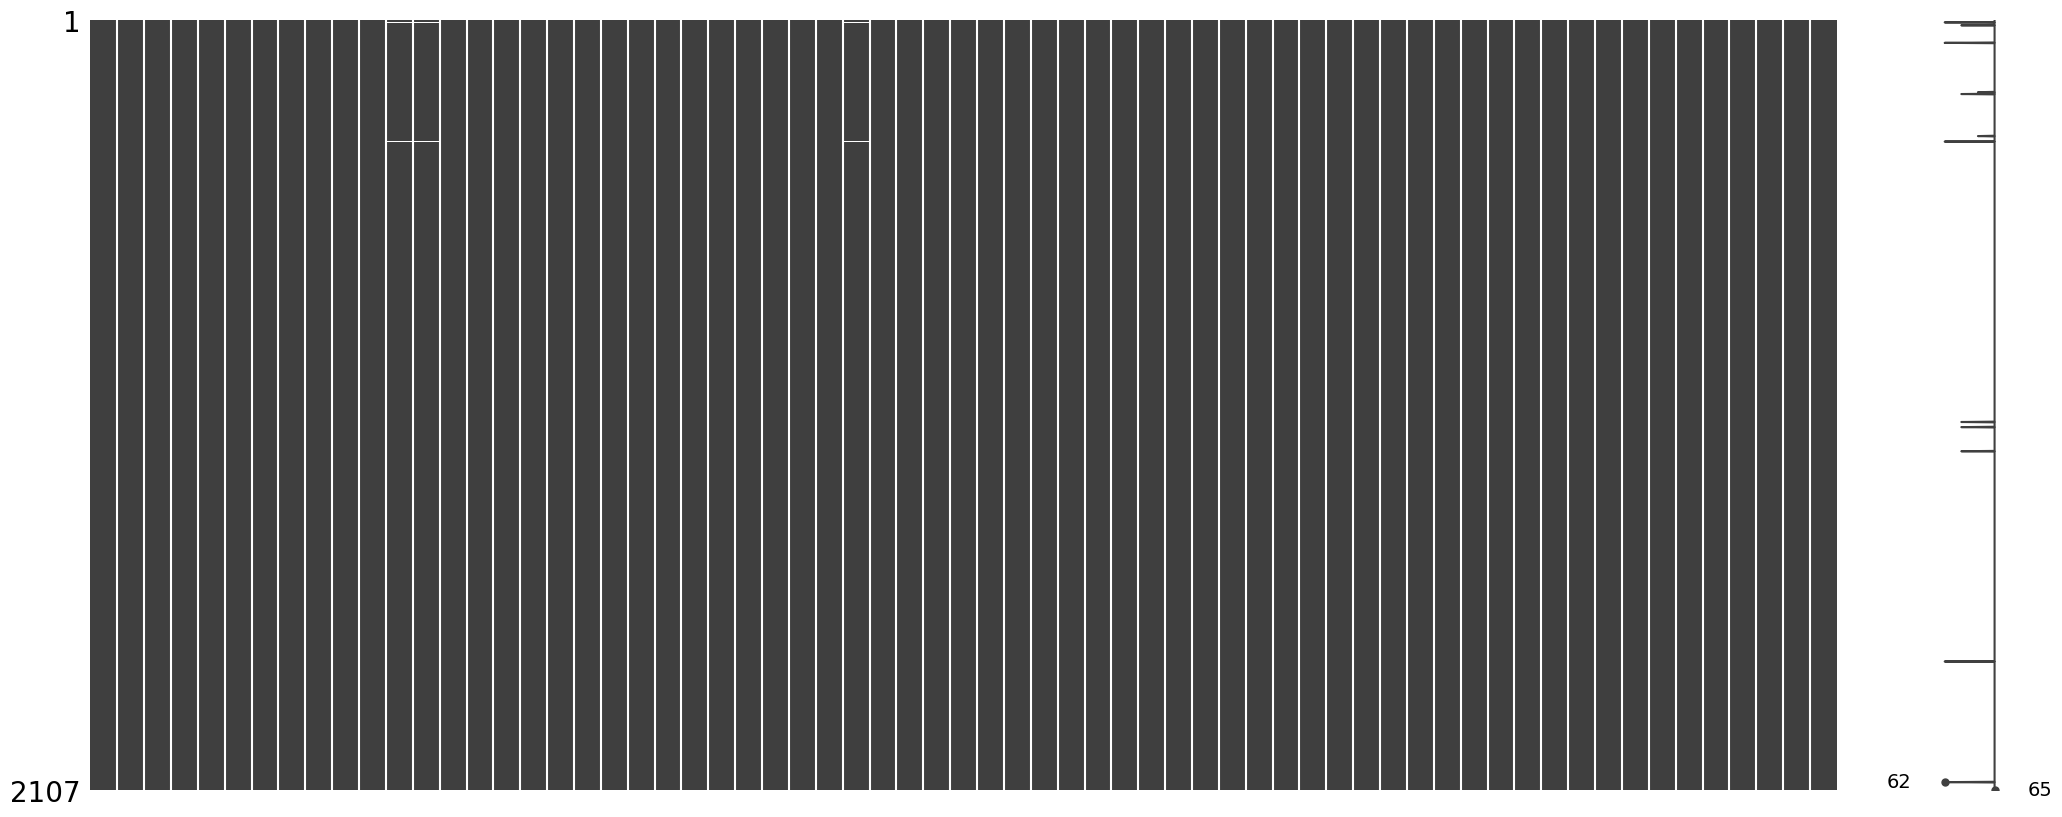

In [35]:
# Visualize missing values in each column
%matplotlib inline
msno.matrix(abt_df01)

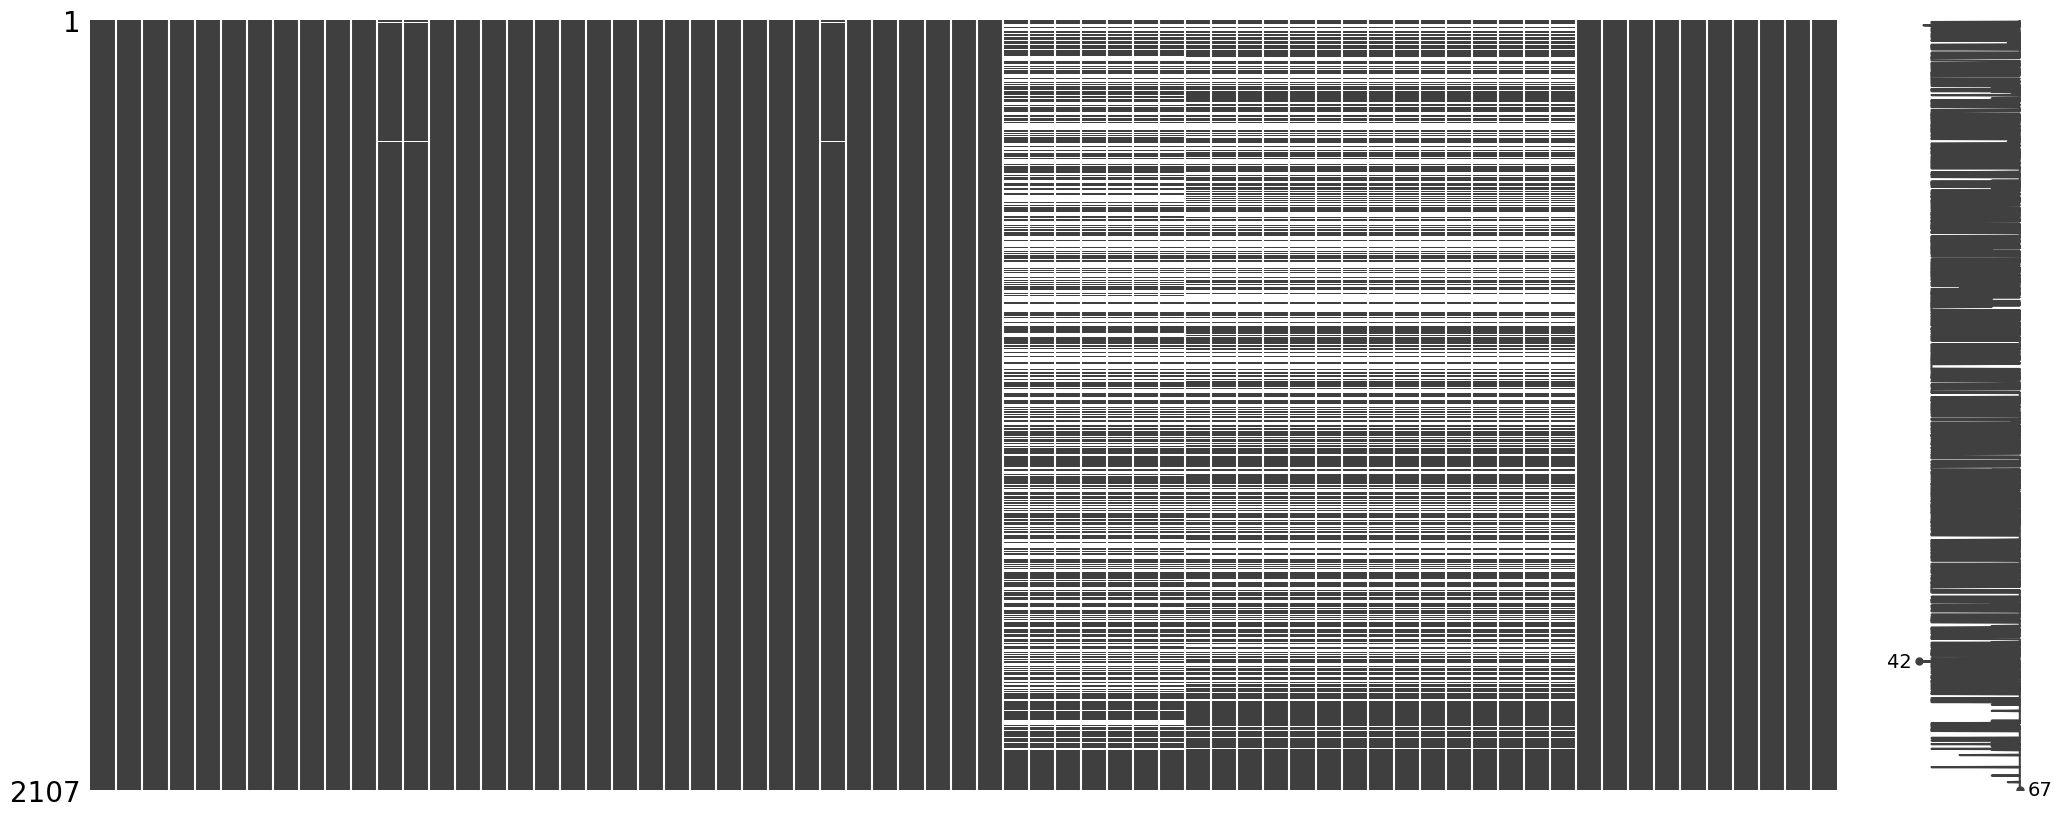

In [36]:
# Visualize missing values in each column
msno.matrix(abt_df02)

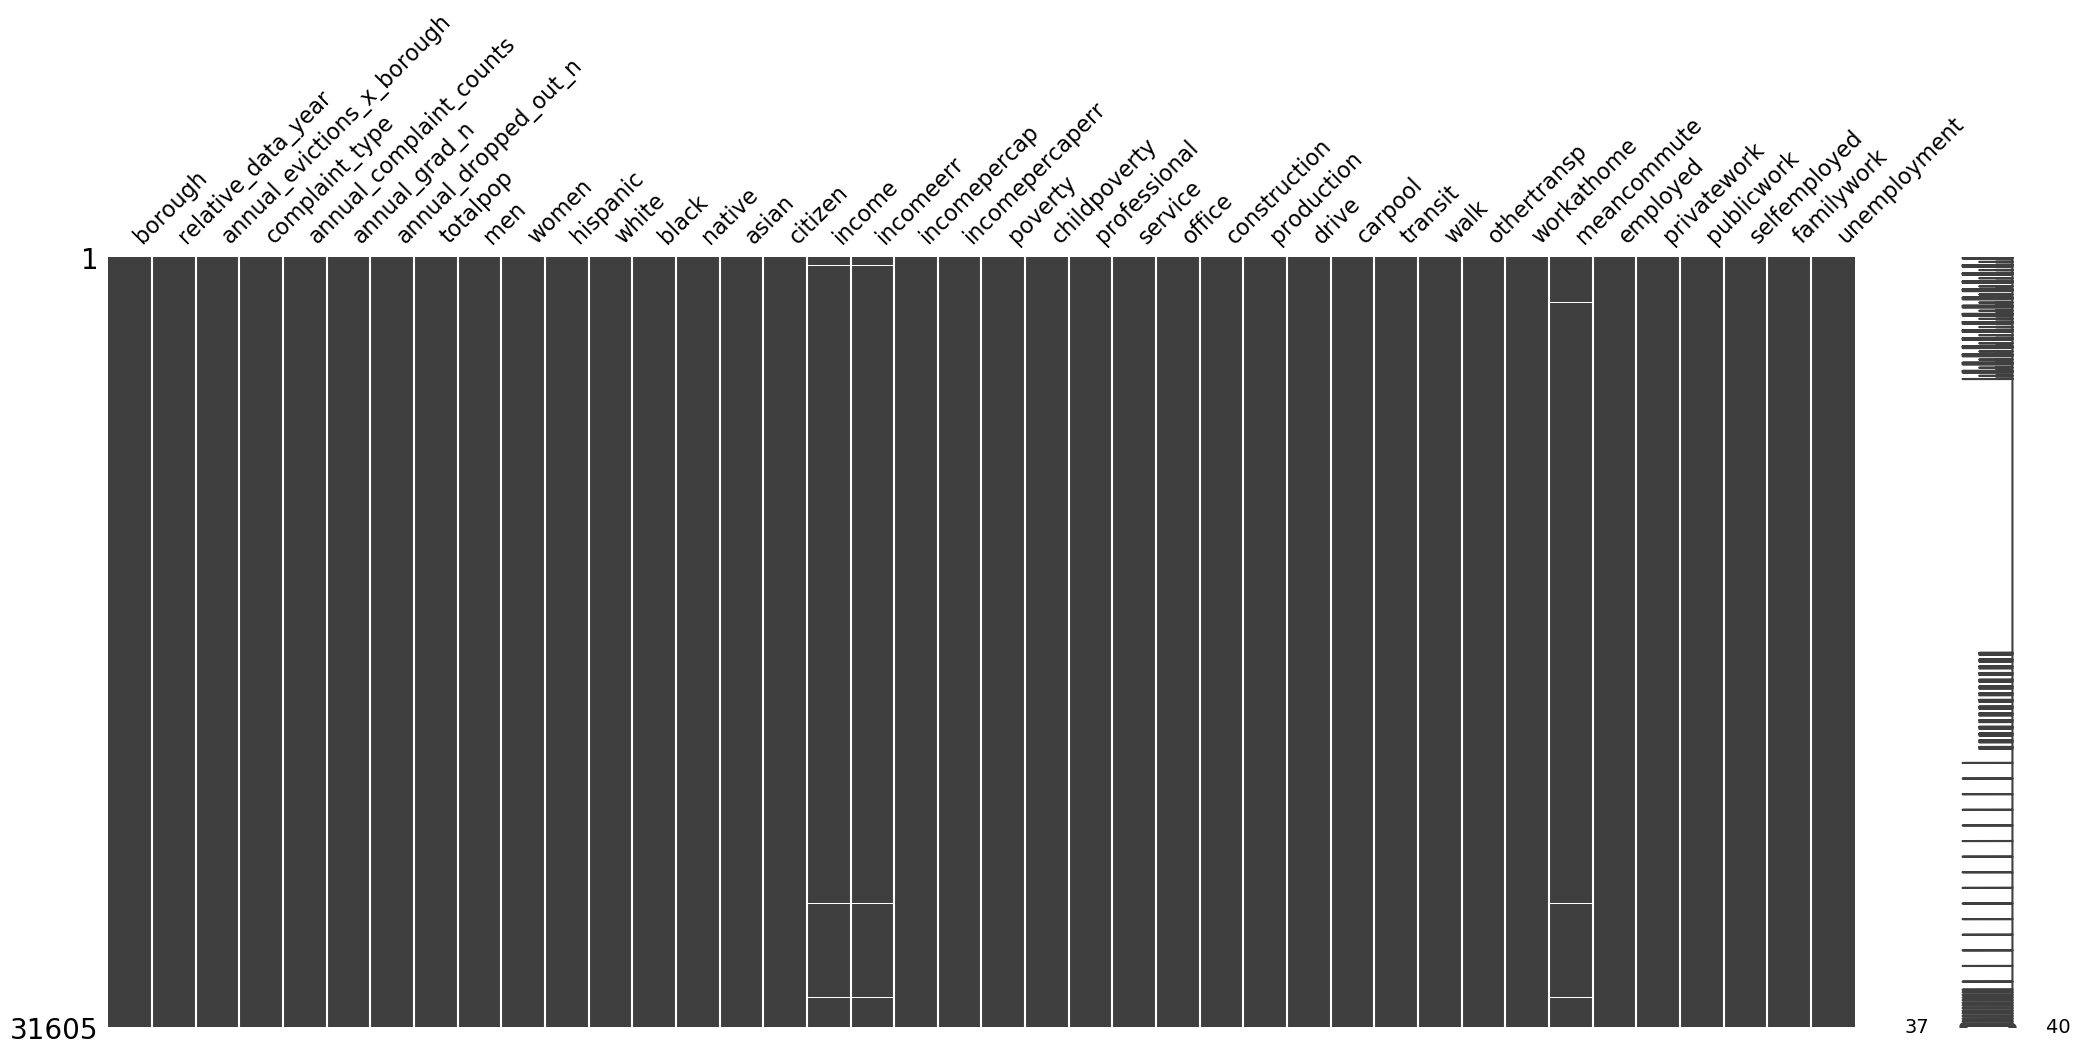

In [45]:
# Visualize missing values in each column
%matplotlib inline
msno.matrix(abt_df03)

In [37]:
# Remove any features for which the number of null vals exceed a threshold--
#-- (15% of total N)
abt_df02_null_summ01 = pd.DataFrame(abt_df02.isnull().sum(),
                                        columns=['null_count'])

abt_df02_null_summ02 = abt_df02_null_summ01.loc[(abt_df02_null_summ01['null_count'] != 0)].sort_values('null_count',
                                                                                                                   ascending=False)
abt_df02_null_summ03 = abt_df02_null_summ02.reset_index()
print(abt_df02_null_summ03)

abt_df02_null_summ04 = abt_df02_null_summ03.loc[abt_df02_null_summ03['null_count'] > (len(abt_df02)*.05)]
print('\n', abt_df02_null_summ04)

abt_df02_null_summ04_remove_lst01 = list(abt_df02_null_summ04['index'])
print('\n', abt_df02_null_summ04_remove_lst01)

#train_x03_tx_df01 = abt_df02.drop(abt_df02_null_summ04_remove_lst01, axis=1)
#test_x03_tx_df01 = test_x02_tx_df01_eda1.drop(abt_df02_null_summ04_remove_lst01, axis=1)

#print(f'\n{train_x03_tx_df01.shape}')
#print(f'\n{test_x03_tx_df01.shape}')

                 index  null_count
0                 2017         857
1                 2018         857
2                 2019         857
3                 2020         857
4                 2021         857
5                 2022         857
6                 2023         857
7     2017 - VIOLATION         808
8        2019 - FELONY         808
9   2021 - MISDEMEANOR         808
10       2021 - FELONY         808
11    2020 - VIOLATION         808
12  2020 - MISDEMEANOR         808
13       2020 - FELONY         808
14    2019 - VIOLATION         808
15  2019 - MISDEMEANOR         808
16    2021 - VIOLATION         808
17    2018 - VIOLATION         808
18  2018 - MISDEMEANOR         808
19       2018 - FELONY         808
20  2017 - MISDEMEANOR         808
21       2017 - FELONY         808
22           incomeerr          10
23              income          10
24         meancommute           7

                  index  null_count
0                 2017         857
1                 

# Show the Tables

In [38]:
show_tbl_stmnt = f"SHOW TABLES in {database_name}"

In [39]:
df_tables = pd.read_sql(show_tbl_stmnt,
                        conn)
df_tables.head(17)

,tab_name
0,abt
1,census
2,census_block
3,crime
4,crime_pqt
5,evictions
6,grad_outcomes
7,hs_info
8,jobs


if abt_tbl_name in df_tables.values:
    ingest_create_athena_table_parquet_passed = True

%store ingest_create_athena_table_parquet_passed

# Run Sample Query

abt_borough01 = 'bronx'

abt_select_borough_stmnt02 = f"""
    SELECT * FROM {database_name}.{abt_tbl_name}
    WHERE blockcode IS NOT NULL
    LIMIT 10000
    """

print(abt_select_borough_stmnt02)

abt_df02_s01 = pd.read_sql(abt_select_borough_stmnt02,
                           conn)

print(abt_df02_s01.shape)
display(abt_df02_s01.head(17))

path_balanced = "./data-clarify/amazon_reviews_us_giftcards_software_videogames_balanced.csv"
df_balanced.to_csv(path_balanced, index=False, header=True)

if not abt_df02_s01.empty:
    print("[OK]")
else:
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOUR DATA HAS NOT BEEN CONVERTED TO PARQUET. LOOK IN PREVIOUS CELLS TO FIND THE ISSUE.")
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")

## Review the New Athena Table in the Glue Catalog

In [40]:
display(
    HTML(
        f'<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={region}#">AWS Glue Catalog</a></b>'
    )
)

## Store Variables for the Next Notebooks

In [41]:
%store

Stored variables and their in-db values:
balanced_bias_data_jsonlines_s3_uri                   -> 's3://sagemaker-us-east-1-657724983756/bias-detect
balanced_bias_data_s3_uri                             -> 's3://sagemaker-us-east-1-657724983756/bias-detect
bias_data_s3_uri                                      -> 's3://sagemaker-us-east-1-657724983756/bias-detect
ingest_create_athena_db_passed                        -> True
ingest_create_athena_table_parquet_passed             -> True
ingest_create_athena_table_tsv_passed                 -> True
s3_private_path_tsv                                   -> 's3://sagemaker-us-east-1-657724983756/team_8_data
s3_public_path_tsv                                    -> 's3://sagemaker-us-east-ads508-sp23-t8'
setup_dependencies_passed                             -> True
setup_iam_roles_passed                                -> True
setup_instance_check_passed                           -> True
setup_s3_bucket_passed                                -> T

# ^^^Execute Above

## Release Resources

%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}